In [3]:
!kaggle datasets download -d aamiraliansari/shelf-images-for-planograms

You should consider upgrading via the 'C:\Users\kongl\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Dataset URL: https://www.kaggle.com/datasets/aamiraliansari/shelf-images-for-planograms


  0%|          | 0.00/224M [00:00<?, ?B/s]
  0%|          | 1.00M/224M [00:01<04:29, 868kB/s]
  1%|          | 2.00M/224M [00:01<02:12, 1.75MB/s]
  1%|▏         | 3.00M/224M [00:01<01:22, 2.81MB/s]
  2%|▏         | 5.00M/224M [00:01<00:50, 4.57MB/s]
  3%|▎         | 7.00M/224M [00:01<00:38, 5.90MB/s]
  4%|▎         | 8.00M/224M [00:02<00:36, 6.25MB/s]
  4%|▍         | 10.0M/224M [00:02<00:27, 8.13MB/s]
  5%|▌         | 12.0M/224M [00:02<00:23, 9.28MB/s]
  6%|▋         | 14.0M/224M [00:02<00:21, 10.0MB/s]
  7%|▋         | 16.0M/224M [00:02<00:20, 10.4MB/s]
  8%|▊         | 18.0M/224M [00:02<00:19, 10.9MB/s]
  9%|▉         | 20.0M/224M [00:03<00:18, 11.3MB/s]
 10%|▉         | 22.0M/224M [00:03<00:18, 11.5MB/s]
 11%|█         | 24.0M/224M [00:03<00:17, 11.7MB/s]
 12%|█▏        | 26.0M/224M [00:03<00:17, 11.8MB/s]
 13%|█▎        | 28.0M/224M [00:03<00:17, 11.9MB/s]
 13%|█▎        | 30.0M/224M [00:03<00:16, 12.0MB/s]
 14%|█▍        | 32.0M/224M [00:04<00:16, 12.0MB/s]
 15%|█▌        | 34.0


License(s): unknown



In [4]:
!pip install cognitive-service-vision-model-customization-python-samples

You should consider upgrading via the 'C:\Users\kongl\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
import json
import logging
import uuid
import os
from zipfile import ZipFile
logging.getLogger().setLevel(logging.INFO)

import cv2
import numpy as np
from PIL import Image


from cognitive_service_vision_model_customization_python_samples import ResourceType
from cognitive_service_vision_model_customization_python_samples.clients import PlanogramComplianceClient, ProductRecognitionClient
from cognitive_service_vision_model_customization_python_samples.models import PlanogramMatchingRequest, ProductRecognition
from cognitive_service_vision_model_customization_python_samples.tools import visualize_matching_result, visualize_planogram

In [6]:
os.makedirs("/root/.kaggle", exist_ok=True)
os.system("mv kaggle.json /root/.kaggle/")

with ZipFile("shelf-images-for-planograms.zip", "r") as zip_ref:
    zip_ref.extractall("shelf_images")

In [62]:
resource_type = ResourceType.SINGLE_SERVICE_RESOURCE
resource_name = "azure-planogram"
multi_service_endpoint = None
resource_key = "FTbjII90RJW9mTfKMD6KG2SU6KpS7eJOu9G5lf1IxRnmRODoFLdWJQQJ99BBACYeBjFXJ3w3AAAFACOGHedl" 

In [35]:
image_path = "sampleinput/test_beverage.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
products = []   
for idx, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    if w > 30 and h > 30:
        product_info = {
            "id": f"product_{idx}",
            "name": "Unknown",
            "w": w,
            "h": h,
            "x": x,
            "y": y
        }
        products.append(product_info)

planogram_json = {
    "planogram": {
        "width": image.shape[1],
        "height": image.shape[0],
        "products": products
    }
}

json_path = "detected_planogram.json"
with open(json_path, "w") as json_file:
    json.dump(planogram_json, json_file, indent=4)

print(f"Planogram JSON saved at: {json_path}")

Planogram JSON saved at: detected_planogram.json


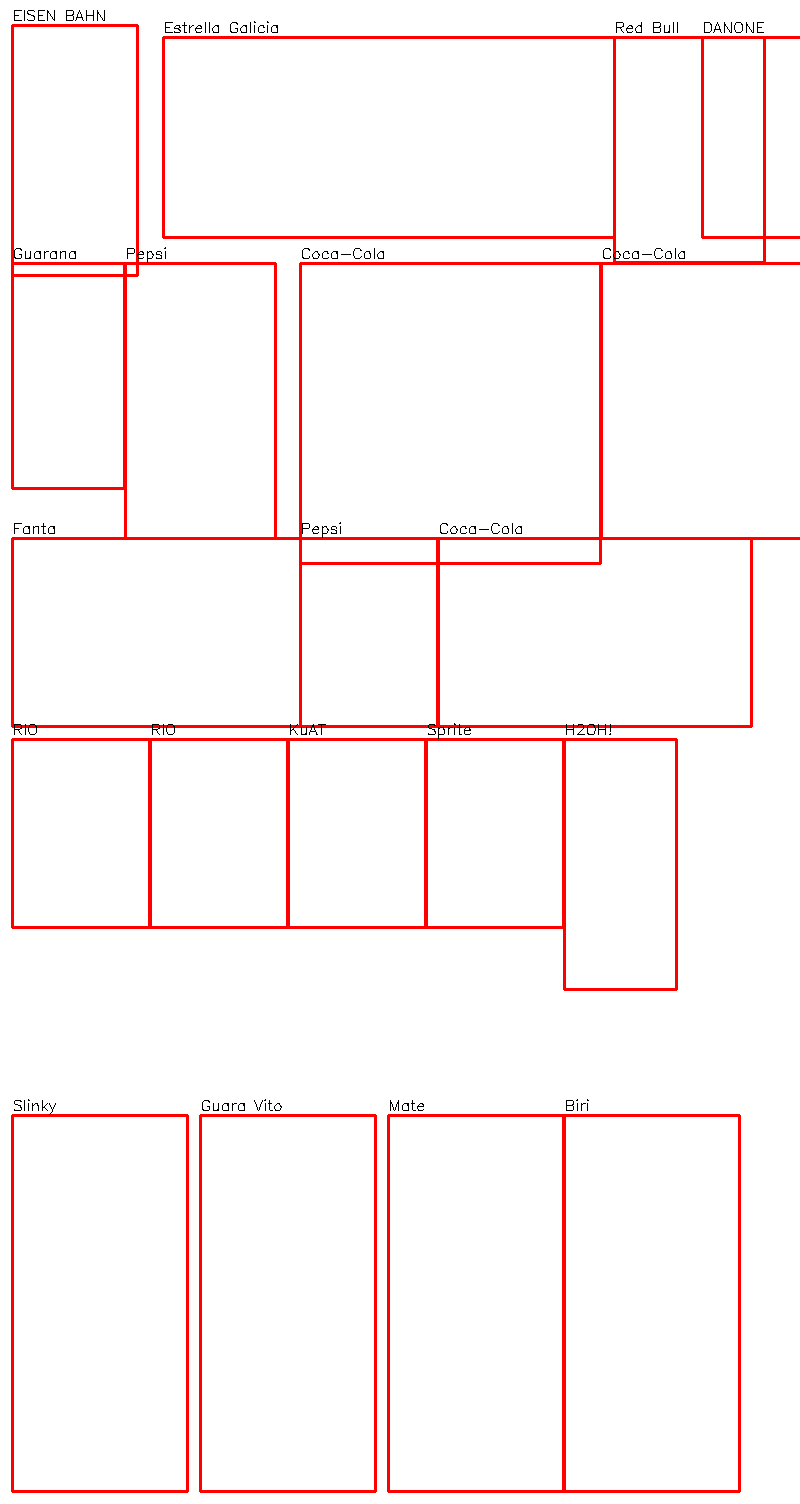

In [40]:
def visualize_planogram(planogram, target_width):
    width = int(planogram['planogram'].get('width'))
    height = int(planogram['planogram'].get('height'))
    aspect_ratio = width / height
    target_height = int(target_width / aspect_ratio)
    image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    image.fill(255)

    for product in planogram['planogram'].get('products', []):
        x = int(product['x'] * target_width / width)
        y = int(product['y'] * target_height / height)
        w = int(product['w'] * target_width / width)
        h = int(product['h'] * target_height / height)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        if 'name' in product:
            cv2.putText(image, product['name'], (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    for fixture in planogram['planogram'].get('fixtures', []):
        x = int(fixture['x'] * target_width / width)
        y = int(fixture['y'] * target_height / height)
        w = int(fixture['w'] * target_width / width)
        h = int(fixture['h'] * target_height / height)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    for position in planogram['planogram'].get('positions', []):
        x = int(position['x'] * target_width / width)
        y = int(position['y'] * target_height / height)
        cv2.circle(image, (x, y), 5, (255, 0, 0), -1)
    return image


planogram = json.load(open('detected_planogram.json', 'r'))
viz_planogram = visualize_planogram(planogram, 800)
viz_planogram = cv2.cvtColor(viz_planogram, cv2.COLOR_BGR2RGB)
display(Image.fromarray(viz_planogram))

In [75]:
client = ProductRecognitionClient(resource_type, resource_name, multi_service_endpoint, resource_key)
run_name = str(uuid.uuid4())
model_name = 'ms-pretrained-product-detection'
run = ProductRecognition(run_name, model_name)

with open('test_beverage.jpg', 'rb') as f:
    img = f.read()
try:
    client.create_run(run, img, 'image/PNG')
    recognition_result = client.wait_for_completion(run_name, model_name)
finally:
    client.delete_run(run_name, model_name)

INFO:cognitive_service_vision_model_customization_python_samples.clients.product_recognition_client:Product recognition finished with state ProductRecognitionStatus.SUCCEEDED.
INFO:cognitive_service_vision_model_customization_python_samples.clients.product_recognition_client:Wall-clock time 0.0 minutes.
INFO:cognitive_service_vision_model_customization_python_samples.clients.product_recognition_client:Product recognition result: {'imageMetadata': {'width': 319, 'height': 600}, 'products': [{'id': '1', 'boundingBox': {'x': 239, 'y': 246, 'w': 30, 'h': 61}, 'tags': [{'name': 'product', 'confidence': 0.8486073017120361}]}, {'id': '2', 'boundingBox': {'x': 173, 'y': 342, 'w': 31, 'h': 54}, 'tags': [{'name': 'product', 'confidence': 0.8366225957870483}]}, {'id': '3', 'boundingBox': {'x': 203, 'y': 340, 'w': 30, 'h': 55}, 'tags': [{'name': 'product', 'confidence': 0.8305624723434448}]}, {'id': '4', 'boundingBox': {'x': 73, 'y': 480, 'w': 37, 'h': 113}, 'tags': [{'name': 'product', 'confidenc

In [89]:
def visualize_recognition_result(result, image):
    if 'products' in result:
        for product in result['products']:
            x = product['boundingBox']['x']
            y = product['boundingBox']['y']
            w = product['boundingBox']['w']
            h = product['boundingBox']['h']
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            if 'tags' in product:
                for tag in product['tags']:
                    cv2.putText(image, tag['name'], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

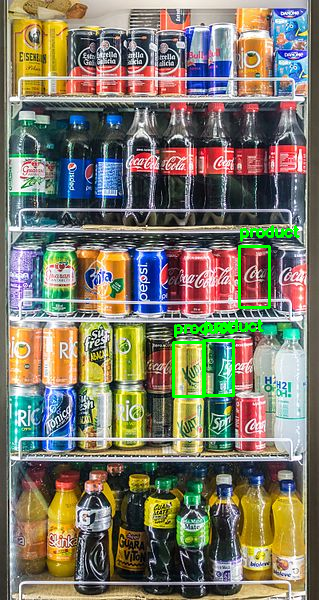

In [ ]:
result = {
    'imageMetadata': {'width': 319, 'height': 600},
    'products': [
        {'id': '1', 'boundingBox': {'x': 239, 'y': 246, 'w': 30, 'h': 61}, 'tags': [{'name': 'product', 'confidence': 0.8486073017120361}]},
        {'id': '2', 'boundingBox': {'x': 173, 'y': 342, 'w': 31, 'h': 54}, 'tags': [{'name': 'product', 'confidence': 0.8366225957870483}]},
        {'id': '3', 'boundingBox': {'x': 203, 'y': 340, 'w': 30, 'h': 55}, 'tags': [{'name': 'product', 'confidence': 0.8305624723434448}]}
    ]
}
cv_img = cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)
cv_img = visualize_recognition_result(result, cv_img)
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
display(Image.fromarray(cv_img))